In [1]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

In [2]:
%matplotlib inline
from tqdm import tqdm
import seaborn as sns
from collections import Counter, OrderedDict
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
from nltk.tokenize import word_tokenize
import itertools
from scipy import stats

In [3]:
transformation_name_map1 = OrderedDict([
    ('orig', 'Original'), ('nonmen_100', '- context'), 
    ('men_100', '- mentions')
])
system_name_map = OrderedDict([
    ('head-match', 'Head-Match'), ('sieve', 'Sieve'), 
    ('cort-pair', 'Cort-MP'), ('cort-latent', 'Cort-MR'), ('cort-tree', 'Cort-EM'), 
    ('deep-coref', 'Deep-Coref'), ('e2e', 'E2E')
])
human_name_map = OrderedDict([
    ('student1', 'annotator1'), ('student2', 'annotator2'), 
    ('student3', 'annotator3'), ('all', 'all-annotators')
])
full_name_map_except_random = OrderedDict(list(system_name_map.items()) +
                                          list(human_name_map.items()))
full_name_map = OrderedDict(list(full_name_map_except_random.items()) +
                            [('random', 'random')])

In [4]:
systems = system_name_map.values()
humans = human_name_map.values()

## Read in results

In [5]:
paths = OrderedDict([
    ('baselines', '../output/baselines-results.csv'),
    ('sieve', '../output/stanford-sieve-results.csv'),
    ('cort', '../output/cort/results.csv'),
    ('deep-coref', '../output/deep-coref/results.csv'),
    ('e2e', '../output/e2e/results.csv'),
    ('students', '../output/mturk/students-results.csv')
])

In [6]:
import pandas as pd
dfs = [pd.read_csv(path) for _, path in paths.items()]
all_results = pd.concat(dfs, sort=False)

In [7]:
all_results.dataset = all_results.dataset.str.replace('dev_test', 'dev+test')

In [8]:
all_results['system'] = all_results.system.str.replace('random-antecedent', 'random')

In [9]:
all_results.columns

Index(['auto_or_gold', 'dataset', 'f1_bcub', 'f1_ceafe', 'f1_conll', 'f1_muc',
       'manipulation', 'mention_p', 'mention_r', 'sample', 'system', 'f1_b3',
       'f1_lea', 'train_manipulation'],
      dtype='object')

In [10]:
all_results[all_results.train_manipulation.notnull() & 
            (all_results.train_manipulation != all_results.manipulation)]

,auto_or_gold,dataset,f1_bcub,f1_ceafe,f1_conll,f1_muc,manipulation,mention_p,mention_r,sample,system,f1_b3,f1_lea,train_manipulation


### Random baseline

In [11]:
random_baseline_results = all_results[(all_results.system == 'random') &
                              (all_results.dataset == 'dev+test')].f1_conll
random_baseline_results.describe()

count    375.000000
mean      37.142827
std        0.432830
min       35.726667
25%       36.876667
50%       37.103333
75%       37.471667
max       38.086667
Name: f1_conll, dtype: float64

In [12]:
random_baseline = random_baseline_results.mean()
random_baseline

37.14282666666664

### Formatting

In [13]:
all_results = all_results[all_results.system.isin(full_name_map)]
all_results['system'] = all_results.system.map(full_name_map.__getitem__)

In [14]:
all_results_except_random = all_results[all_results.system != 'random']

# Check the results

### Checking that we have some variation across samples

In [15]:
head_match_results = all_results[all_results.system == 'Head-Match']

In [16]:
head_match_results.pivot(index='sample', columns='manipulation', values='f1_conll').describe()

manipulation,men_100,men_20,men_40,men_60,men_80,no-external,no-internal,no-match,no-name,nonmen_100,nonmen_20,nonmen_40,nonmen_60,nonmen_80,orig
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,39.394000,52.149200,50.067333,50.517067,50.558000,61.867333,61.872933,48.777467,58.219333,60.908400,60.921200,60.955200,60.942933,60.942933,60.921200
std,0.339563,0.221195,0.199745,0.142959,0.150200,0.297163,0.297653,0.367072,0.250657,0.305511,0.305952,0.305645,0.305478,0.305478,0.305952
min,38.616667,51.793333,49.563333,50.283333,50.306667,61.223333,61.230000,48.173333,57.793333,60.453333,60.463333,60.463333,60.453333,60.453333,60.463333
25%,39.243333,52.000000,49.960000,50.416667,50.486667,61.660000,61.660000,48.460000,58.056667,60.686667,60.686667,60.766667,60.766667,60.766667,60.686667
50%,39.330000,52.106667,50.076667,50.510000,50.536667,61.833333,61.840000,48.776667,58.173333,60.856667,60.856667,60.896667,60.896667,60.896667,60.856667
75%,39.600000,52.323333,50.190000,50.656667,50.683333,62.000000,62.003333,49.080000,58.343333,61.166667,61.193333,61.276667,61.256667,61.256667,61.193333
max,40.026667,52.716667,50.430000,50.710000,50.846667,62.500000,62.503333,49.443333,58.803333,61.470000,61.480000,61.480000,61.470000,61.470000,61.480000


### Why does head-match get so high a result on men-100?

I checked the file `output/baselines/head-match__output__conll-2012-transformed-resampled__sample_24__men_100__dev_test.m_gold_conll` and it indeed contains only one cluster per document.

In [17]:
men100_results = all_results[all_results.manipulation == 'men_100']
(men100_results.groupby(['auto_or_gold', 'dataset', 'system'])
 .agg(['mean', 'std'])[['f1_bcub', 'f1_ceafe', 'f1_muc', 'f1_conll']])

f1_bcub           f1_ceafe            \
                                         mean       std     mean       std   
auto_or_gold dataset  system                                                 
auto         dev+test all-annotators  62.4348  1.334891  49.0604  2.742738   
                      annotator1      58.7800  0.000000  43.2100  0.000000   
                      annotator2      62.4288  1.455456  50.7648  2.405425   
                      annotator3      51.0432  0.298632  29.5432  0.009000   
gold         dev+test Cort-EM         26.0208  0.522772   9.2332  0.305801   
                      Cort-MP         24.0960  0.271401  31.2784  0.358860   
                      Cort-MR         38.5420  0.422473  29.7764  0.373083   
                      Deep-Coref          NaN       NaN   6.5400  0.000000   
                      E2E             50.2812  0.442637  50.7060  0.426478   
                      Head-Match      24.0272  0.602159   6.5084  0.297849   
                      Sieve               NaN       NaN      NaN       NaN   
                      random          28.4004  0.555064  17.0856  0.559271   

                                       f1_muc             f1_conll            
                                         mean       std       mean       std  
auto_or_gold dataset  system                                                  
auto         dev+test all-annotators  67.0096  2.192237  59.501600  1.742909  
                      annotator1      46.4200  0.000000  49.470000  0.000000  
                      annotator2      69.3044  2.648822  60.832667  1.722269  
                      annotator3      28.4772  3.541315  36.354533  1.084519  
gold         dev+test Cort-EM         84.7140  0.406807  39.989333  0.307021  
                      Cort-MP         33.6228  0.529729  29.665733  0.240762  
                      Cort-MR         68.3924  0.695882  45.570267  0.347668  
                      Deep-Coref      87.3500  0.000000  39.260000  0.000000  
                      E2E             63.7804  0.614603  54.922000  0.404907  
                      Head-Match      87.6464  0.222727  39.394000  0.339563  
                      Sieve               NaN       NaN  19.428000  0.779904  
                      random          65.8532  0.749737  37.113067  0.460895

### How well people actually perform on context-masked documents?


In [18]:
nonmen_vs_orig_results = all_results[all_results.manipulation.isin(['orig', 'nonmen_100'])]
(nonmen_vs_orig_results.groupby(['auto_or_gold', 'dataset', 'system', 'manipulation'])
 .agg(['mean', 'std'])[['f1_bcub', 'f1_ceafe', 'f1_muc', 'f1_conll']])

f1_bcub           f1_ceafe  \
                                                      mean       std     mean   
auto_or_gold dataset  system         manipulation                               
auto         dev+test all-annotators nonmen_100    90.5388  1.282817  85.7068   
                                     orig          92.7960  1.173882  87.1956   
                      annotator1     nonmen_100    83.9416  1.596391  72.5296   
                                     orig          87.0988  1.494376  79.2924   
                      annotator2     nonmen_100    91.3068  0.880751  87.7292   
                                     orig          95.4740  1.066486  93.0244   
                      annotator3     nonmen_100    95.2376  1.898136  85.6188   
                                     orig          92.0720  0.876694  83.8992   
gold         dev+test Cort-EM        nonmen_100    78.7364  0.400550  77.5400   
                                     orig          79.1412  0.392973  77.5544   
                      Cort-MP        nonmen_100    76.9504  0.492819  76.3092   
                                     orig          77.0016  0.387316  75.8908   
                      Cort-MR        nonmen_100    79.1148  0.386136  77.4716   
                                     orig          79.3124  0.407649  77.4664   
                      Deep-Coref     nonmen_100        NaN       NaN  79.3400   
                                     orig              NaN       NaN  79.2572   
                      E2E            nonmen_100    82.5048  0.307302  81.3036   
                                     orig          83.2200  0.242212  81.2088   
                      Head-Match     nonmen_100    62.7712  0.518381  49.9296   
                                     orig          62.7748  0.518340  49.9376   
                      Sieve          nonmen_100        NaN       NaN      NaN   
                                     orig              NaN       NaN      NaN   
                      random         nonmen_100    28.3700  0.475526  17.0772   
                                     orig          28.4124  0.517198  17.1120   

                                                              f1_muc  \
                                                        std     mean   
auto_or_gold dataset  system         manipulation                      
auto         dev+test all-annotators nonmen_100    1.821013  93.7884   
                                     orig          2.125582  95.6696   
                      annotator1     nonmen_100    3.738389  78.8844   
                                     orig          2.113041  91.8300   
                      annotator2     nonmen_100    1.110112  94.6940   
                                     orig          1.906367  98.0020   
                      annotator3     nonmen_100    6.907948  95.7864   
                                     orig          1.129192  93.9196   
gold         dev+test Cort-EM        nonmen_100    0.335857  89.0568   
                                     orig          0.329761  89.4036   
                      Cort-MP        nonmen_100    0.463887  86.8244   
                                     orig          0.350047  86.8592   
                      Cort-MR        nonmen_100    0.309148  89.1952   
                                     orig          0.319777  89.5112   
                      Deep-Coref     nonmen_100    0.000000  90.1400   
                                     orig          0.019044  90.4528   
                      E2E            nonmen_100    0.257308  90.9656   
                                     orig          0.350373  91.5220   
                      Head-Match     nonmen_100    0.358614  70.0244   
                                     orig          0.357180  70.0512   
                      Sieve          nonmen_100         NaN      NaN   
                                     orig               NaN      NaN   
                      random         nonmen_100    0.364766  65

### Counting and eyeballing

In [19]:
all_results.manipulation.value_counts()

nonmen_80      300
no-external    300
no-name        300
men_20         300
nonmen_40      300
nonmen_100     300
nonmen_20      300
orig           300
no-internal    300
men_60         300
men_40         300
men_100        300
men_80         300
nonmen_60      300
no-match       200
Name: manipulation, dtype: int64

In [20]:
all_results.head()

,auto_or_gold,dataset,f1_bcub,f1_ceafe,f1_conll,f1_muc,manipulation,mention_p,mention_r,sample,system,f1_b3,f1_lea,train_manipulation
0,gold,dev+test,24.57,6.97,39.743333,87.69,men_100,100.0,100.0,sample_00,Head-Match,NaN,NaN,NaN
1,gold,dev+test,53.73,44.02,52.540000,59.87,men_20,100.0,100.0,sample_00,Head-Match,NaN,NaN,NaN
2,gold,dev+test,50.08,41.59,50.176667,58.86,men_40,100.0,100.0,sample_00,Head-Match,NaN,NaN,NaN
3,gold,dev+test,49.59,38.59,50.493333,63.30,men_60,100.0,100.0,sample_00,Head-Match,NaN,NaN,NaN
4,gold,dev+test,45.33,34.25,50.846667,72.96,men_80,100.0,100.0,sample_00,Head-Match,NaN,NaN,NaN


In [21]:
# look at one type of transformation/system
all_results[(all_results.system == 'E2E') & (all_results.manipulation == 'men_80') & 
            (all_results.dataset == 'dev+test')].describe()

,f1_bcub,f1_ceafe,f1_conll,f1_muc,mention_p,mention_r,f1_b3,f1_lea
count,25.000000,25.00000,25.000000,25.000000,25.0,25.00000,0.0,0.0
mean,52.180800,51.82880,56.989600,66.958000,100.0,90.70480,NaN,NaN
std,0.430348,0.37427,0.364503,0.579684,0.0,0.22004,NaN,NaN
min,51.510000,51.30000,56.380000,65.720000,100.0,90.23000,NaN,NaN
25%,51.870000,51.56000,56.720000,66.670000,100.0,90.56000,NaN,NaN
50%,52.170000,51.87000,56.990000,66.990000,100.0,90.71000,NaN,NaN
75%,52.340000,52.03000,57.220000,67.400000,100.0,90.91000,NaN,NaN
max,53.380000,52.72000,57.600000,68.420000,100.0,91.05000,NaN,NaN


In [22]:
all_results.system.unique()

array(['Head-Match', 'random', 'Sieve', 'Cort-MR', 'Cort-MP', 'Cort-EM',
       'Deep-Coref', 'E2E', 'all-annotators', 'annotator1', 'annotator2',
       'annotator3'], dtype=object)

In [39]:
# look at one type of transformation/system
all_results[(all_results.system == 'Deep-Coref') & (all_results.dataset == 'dev+test')] \
    .groupby(['auto_or_gold', 'dataset', 'manipulation', 'system']).agg({'f1_conll': 'mean'})

f1_conll
auto_or_gold dataset  manipulation system              
gold         dev+test men_100      Deep-Coref   39.2600
                      men_20       Deep-Coref   73.3300
                      men_40       Deep-Coref   64.4500
                      men_60       Deep-Coref   42.4000
                      men_80       Deep-Coref   39.2700
                      no-external  Deep-Coref   81.9600
                      no-internal  Deep-Coref   82.1700
                      no-match     Deep-Coref   74.9700
                      no-name      Deep-Coref   75.7300
                      nonmen_100   Deep-Coref   83.7900
                      nonmen_20    Deep-Coref   83.9300
                      nonmen_40    Deep-Coref   83.7600
                      nonmen_60    Deep-Coref   83.7460
                      nonmen_80    Deep-Coref   83.6592
                      orig         Deep-Coref   84.0652

In [40]:
84.0652 - 83.7900

0.2751999999999981

In [24]:
# check that there's some variation in e2e results
(all_results[(all_results.system == 'E2E') & (all_results.dataset == 'dev+test')]
 .groupby(['system', 'manipulation', 'train_manipulation']).agg({'f1_conll': lambda x: [np.mean(x), np.std(x)]}))

f1_conll
system manipulation train_manipulation                                           
E2E    men_100      men_100             [54.922000000000004, 0.39672660611559635]
       men_20       men_20                [74.81880000000001, 0.2015603135540326]
       men_40       men_40               [66.97160000000001, 0.31153401098435446]
       men_60       men_60               [61.20919999999999, 0.34712441573591407]
       men_80       men_80               [56.98960000000001, 0.35713840454367307]
       no-external  no-external           [82.34440000000001, 0.2623140103006321]
       no-internal  no-internal           [82.19400000000002, 0.2227464926772124]
       no-match     no-match             [76.66919999999999, 0.24404786415783158]
       no-name      no-name              [76.69199999999996, 0.28197872260154616]
       nonmen_100   nonmen_100           [84.92479999999999, 0.19146007416691255]
       nonmen_20    nonmen_20                      [85.2084, 0.20150791547728356]
       nonmen_40    nonmen_40                      [85.0696, 0.21708026165453082]
       nonmen_60    nonmen_60            [84.74680000000001, 0.21008036557470083]
       nonmen_80    nonmen_80                       [84.7216, 0.2768780236855217]
       orig         orig                 [85.31719999999997, 0.19787915504165624]

In [25]:
# check that there's some variation in deep-coref results
(all_results[(all_results.system == 'Deep-Coref') & (all_results.dataset == 'dev+test')]
 .groupby(['system', 'manipulation']).agg({'f1_conll': lambda x: np.std(x)}))

f1_conll
system     manipulation              
Deep-Coref men_100       0.000000e+00
           men_20        2.842171e-14
           men_40        2.842171e-14
           men_60        7.105427e-15
           men_80        1.421085e-14
           no-external   2.842171e-14
           no-internal   1.421085e-14
           no-match      1.421085e-14
           no-name       0.000000e+00
           nonmen_100    2.842171e-14
           nonmen_20     2.842171e-14
           nonmen_40     0.000000e+00
           nonmen_60     8.000000e-03
           nonmen_80     1.998399e-02
           orig          6.530666e-02

# Mentions and context affecting systems

In [26]:
df = all_results_except_random
ex1_results = df[df.manipulation.isin(['orig', 'nonmen_100', 'men_100']) &
                 ((df.auto_or_gold == 'gold') | (df.system.isin(humans))) & 
                 (df.dataset == 'dev+test')].copy()
ex1_results['manipulation'] = ex1_results.manipulation.map(transformation_name_map1.__getitem__)

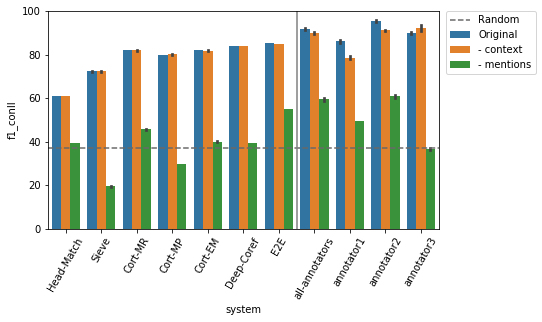

In [27]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(x='system', y='f1_conll', hue='manipulation', 
                 hue_order=transformation_name_map1.values(), 
                 data=ex1_results, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
ax.axhline(random_baseline, ls='--', color='dimgrey', label='Random')
ax.axvline(len(systems)-0.5, ls='-', color='grey')
ax.set_ylim(0, 100)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
None

In [28]:
ex1_results[(ex1_results.manipulation == '- context') & (ex1_results.system.isin(systems))].f1_conll.max()

85.27

In [29]:
# ex1_results_pivot = ex1_results.pivot(index='system', columns='manipulation', values='f1_conll')
# ex1_results_pivot['context_effect'] = ex1_results_pivot['- context'] - ex1_results_pivot['Original']
# ex1_results_pivot

## More details about head-match results

In [58]:
!grep -E 'METRIC|Coreference' ../output/baselines/*head*__men_100*.log | grep -A 1 bcub | grep Precision

../output/baselines/head-match__output__conll-2012-transformed-resampled__sample_00__men_100__dev_test.m_gold_conll.log:Coreference: Recall: (36587 / 36587) 100%	Precision: (5125.43248899825 / 36587) 14%	F1: 24.57%
../output/baselines/head-match__output__conll-2012-transformed-resampled__sample_01__men_100__dev_test.m_gold_conll.log:Coreference: Recall: (38989 / 38989) 100%	Precision: (5277.58824823888 / 38989) 13.53%	F1: 23.84%
../output/baselines/head-match__output__conll-2012-transformed-resampled__sample_02__men_100__dev_test.m_gold_conll.log:Coreference: Recall: (38456 / 38456) 100%	Precision: (5249.24026109211 / 38456) 13.64%	F1: 24.02%
../output/baselines/head-match__output__conll-2012-transformed-resampled__sample_03__men_100__dev_test.m_gold_conll.log:Coreference: Recall: (37164 / 37164) 100%	Precision: (5351.14622775105 / 37164) 14.39%	F1: 25.17%
../output/baselines/head-match__output__conll-2012-transformed-resampled__sample_04__men_100__dev_test.m_gold_conll.log:Coreference

In [59]:
precision_strs = '''14
13.53
13.64
14.39
13.42
13.91
13.45
13.4
13.46
13.63
14.21
12.84
13.58
12.76
13.62
13.93
14.17
13.8
13.68
13.45
13.95
14.09
13.53
13.2
13.66'''.split()

In [60]:
precisions = [float(s) for s in precision_strs]

In [102]:
np.mean(precisions)

13.652000000000001

## Some stats about manual annotations

In [26]:
f1_conlls = (all_results[all_results.system.str.match('annotator')]
             .groupby(['auto_or_gold', 'dataset', 'manipulation', 'system'])
             .agg({'f1_conll': list})
             .reset_index().pivot(index='system', columns='manipulation', values='f1_conll'))

In [27]:
f1_conlls[['orig', 'nonmen_100', 'men_100']]

manipulation,orig,nonmen_100,men_100
system,,,
annotator1,"[84.76, 85.58999999999997, 86.70666666666666, ...","[78.05333333333333, 78.05333333333333, 78.0533...","[49.47, 49.47, 49.47, 49.47, 49.47, 49.47, 49...."
annotator2,"[95.18333333333334, 96.80666666666669, 93.64, ...","[91.01333333333334, 90.57, 91.29333333333334, ...","[59.06666666666666, 61.95, 61.85333333333333, ..."
annotator3,"[88.66000000000003, 90.43, 89.15666666666667, ...","[89.47333333333331, 90.96, 95.83, 90.96, 85.94...","[35.91333333333333, 35.91333333333333, 35.9133..."


In [28]:
def ttest_diff_nonmen_orig(annotator):
    vals1 = f1_conlls['orig'].loc[annotator]
    vals2 = f1_conlls['nonmen_100'].loc[annotator]
    print('Difference of means:', np.mean(vals1)-np.mean(vals2))
    return stats.ttest_ind(vals1, vals2, equal_var=False)

In [29]:
ttest_diff_nonmen_orig('annotator1')

Difference of means: 7.621866666666676


Ttest_indResult(statistic=12.844465515982828, pvalue=1.9582558862710963e-15)

In [30]:
ttest_diff_nonmen_orig('annotator2')

Difference of means: 4.256799999999998


Ttest_indResult(statistic=15.487407843555587, pvalue=3.421377093472383e-19)

In [31]:
ttest_diff_nonmen_orig('annotator3')

Difference of means: -2.2506666666666604


Ttest_indResult(statistic=-2.981430767451941, pvalue=0.006060806730944263)

## Looking closer into mention-masking

In [30]:
selected_manipulations = ['orig', 'men_20', 'men_40', 'men_60', 'men_80', 'men_100']
selected_name_map = OrderedDict(full_name_map_except_random.items())
del selected_name_map['all'] # make the plot less clustered

In [31]:
ex3_results = all_results_except_random.copy()
is_selected_system = (ex3_results.system.isin(selected_name_map.values()) & (ex3_results.dataset == 'dev+test'))
ex3_results = (ex3_results[ex3_results.manipulation.isin(selected_manipulations) & is_selected_system])
ex3_results['type'] = ex3_results.system.map(lambda x: 'human' if 'annotator' in x else 'automatic')
ex3_results['% masked'] = ex3_results.manipulation.str.replace('men_', '').replace('orig', '0').astype(int)

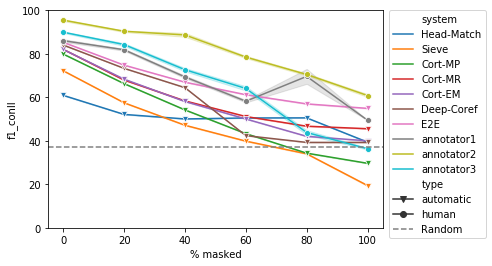

In [32]:
ax = sns.lineplot(x='% masked', y='f1_conll', hue='system', style='type', 
                  hue_order = selected_name_map.values(),
                  style_order = ['automatic', 'human'],
                  markers=['v', 'o'], dashes=False,
                  data=ex3_results)
ax.axhline(random_baseline, ls='--', color='grey', label='Random')
ax.set_ylim(0, 100)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
None

In [33]:
import scipy

def compute_auc(x=None, y=None, hue=None, data=None):
    auc_df = []
    for hue_val, group in data.groupby(hue):
        x_vals = group[x].values
        f_vals = group[y].values
        max_f_vals = [100]*len(x_vals)
        auc = scipy.integrate.simps(f_vals, x_vals) / scipy.integrate.simps(max_f_vals, x_vals)
        auc_df.append(OrderedDict([(hue, hue_val), (y+'_auc', auc)]))
    return pd.DataFrame(auc_df)

In [34]:
# compute_auc(x='% masked', y='f1_conll', hue='system', data=ex3_results)

## Looking closer into context-masking

In [35]:
selected_manipulations = ['orig', 'nonmen_20', 'nonmen_40', 'nonmen_60', 'nonmen_80', 'nonmen_100']

In [36]:
df = all_results_except_random
ex3b_results = (df[df.manipulation.isin(selected_manipulations) & is_selected_system]).copy()
ex3b_results['type'] = ex3b_results.system.map(lambda x: 'human' if 'annotator' in x else 'automatic')
ex3b_results['% masked'] = ex3b_results.manipulation.str.replace('nonmen_', '').replace('orig', '0').astype(int)

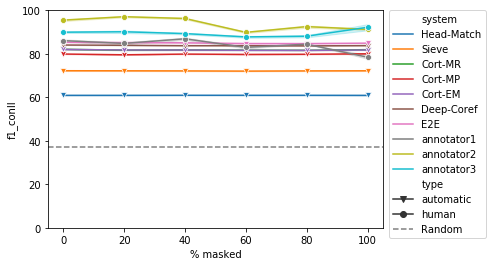

In [37]:
ax = sns.lineplot(x='% masked', y='f1_conll', hue='system', 
                  style='type', data=ex3b_results,
                  markers=['v', 'o'], dashes=False
                 )
ax.set_ylim(0, 100)
ax.axhline(random_baseline, ls='--', color='grey', label='Random')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
None

# Experiment 3: Summarization

In [40]:
summaries = pd.read_json('../output/summaries_formatted.json', orient='records', lines=True)

In [41]:
summaries = summaries.rename(columns={'pct_change': '% masked'})

In [42]:
len(summaries)

210

In [43]:
def average_sent_length(sents):
    sents_tokenized = [word_tokenize(s) for s in sents]
    sents_words_only = [[w for w in sent if w not in string.punctuation] 
                        for sent in sents_tokenized]
    lens = [len(s) for s in sents_words_only]
    return np.mean(lens) if lens else 0

summaries['Average length'] = summaries.sents.apply(average_sent_length)
summaries['Number of sentences'] = summaries.sents.apply(len)

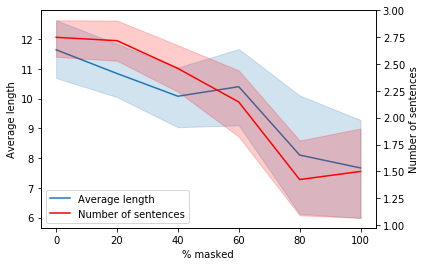

In [44]:
fig, ax = plt.subplots()
g = sns.lineplot(x='% masked', y='Average length', data=summaries, ax=ax)
ax2 = ax.twinx()
g2 = sns.lineplot(x='% masked', y='Number of sentences', data=summaries, ax=ax2, color='r')
plt.legend(g.get_lines() + g2.get_lines(), ['Average length', 'Number of sentences'], loc='lower left')
None

In [45]:
gt80 = (summaries['% masked'] >= 80)
sum(gt80 & (summaries['Number of sentences'] == 3)) / sum(gt80)

0.2698412698412698

# Experiment: Name processing in systems

In [41]:
transformation_name_map2 = OrderedDict([
  ('orig', 'Original'), ('no-external', '- External'), ('no-internal', '- Internal'), 
  ('no-match', '- Match'), ('no-name', 'Masked')
])

In [42]:
df = all_results_except_random
ex4_results = df[df.manipulation.isin(transformation_name_map2) &
                          (df.auto_or_gold == 'gold') & 
                          (df.dataset == 'dev+test')].copy()
ex4_results['manipulation'] = ex4_results.manipulation.map(transformation_name_map2.__getitem__)

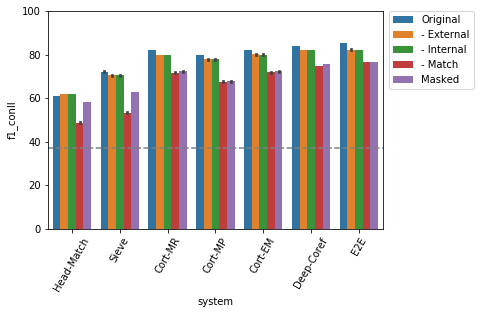

In [43]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x='system', y='f1_conll', hue='manipulation', data=ex4_results,
            hue_order=transformation_name_map2.values(), ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
ax.axhline(random_baseline, ls='--', color='grey')
ax.set_ylim(0, 100)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
None

In [49]:
fitlered_results = ex4_results.groupby(['system', 'manipulation']).agg(['mean', 'std'])['f1_conll'].reset_index()
diff_results = fitlered_results.pivot(index='system', columns='manipulation', values='mean')
diff_results['diff(orig-masked)'] = diff_results['Original'] - diff_results['Masked']
diff_results['diff(orig-external)'] = diff_results['Original'] - diff_results['- External']
diff_results['diff(orig-interanl)'] = diff_results['Original'] - diff_results['- Internal']
diff_results

manipulation,- External,- Internal,- Match,Masked,Original,diff(orig-masked),diff(orig-external),diff(orig-interanl)
system,,,,,,,,
Cort-EM,80.130133,80.007467,71.830400,72.312933,82.033067,9.720133,1.902933,2.025600
Cort-MP,77.786533,77.816533,67.621200,67.682000,79.917200,12.235200,2.130667,2.100667
Cort-MR,79.967600,79.962667,71.716267,72.282800,82.096667,9.813867,2.129067,2.134000
Deep-Coref,67.630000,67.870000,61.160000,62.100000,68.680000,6.580000,1.050000,0.810000
E2E,82.344400,82.194000,76.669200,76.692000,85.317200,8.625200,2.972800,3.123200
Head-Match,61.867333,61.872933,48.777467,58.219333,60.921200,2.701867,-0.946133,-0.951733
Sieve,70.534800,70.528400,53.256400,62.865600,72.238800,9.373200,1.704000,1.710400


## Cross-manipulation evaluation

- cross-eval1: trained on `orig`, tested on `no-internal`
- cross-eval2: trained on `no-internal`, tested on `orig`

In [73]:
!tail -n 5 ../output/e2e/eval-cross/*

==> ../output/e2e/eval-cross/cross-eval1.log <==

Average F1 (conll): 76.54%
Average F1 (py): 76.55%
Average precision (py): 78.34%
Average recall (py): 76.31%

==> ../output/e2e/eval-cross/cross-eval2.log <==

Average F1 (conll): 80.47%
Average F1 (py): 80.48%
Average precision (py): 82.35%
Average recall (py): 79.15%


In [75]:
80.47 - 85.317200

-4.847200000000001

In [76]:
76.54 - 82.194000

-5.653999999999996

# Experiment: Name processing in humans

In [50]:
transformation_name_map3 = OrderedDict([
  ('orig', 'Original'), ('no-external', 'Mapped'), ('no-internal', 'Mapped'), 
  ('no-name', 'Masked')
])

In [51]:
df = all_results_except_random
ex5_results = df[df.manipulation.isin(transformation_name_map2) &
                          df.system.isin(humans) & (df.dataset == 'dev+test')].copy()
ex5_results['manipulation'] = ex5_results.manipulation.map(transformation_name_map3.__getitem__)

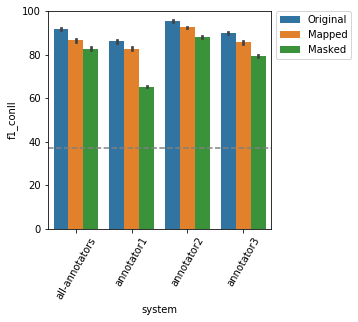

In [52]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.barplot(x='system', y='f1_conll', hue='manipulation', data=ex5_results,
            hue_order=['Original', 'Mapped', 'Masked'], ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
ax.axhline(random_baseline, ls='--', color='grey')
ax.set_ylim(0, 100)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
None

## Compute the contribution of the resolution of names

In [53]:
fitlered_results = ex5_results.groupby(['system', 'manipulation']).agg(['mean', 'std'])['f1_conll'].reset_index()
diff_results = fitlered_results.pivot(index='system', columns='manipulation', values='mean')
diff_results['diff(orig-masked)'] = diff_results['Original'] - diff_results['Masked']
diff_results['diff(orig-mapped)'] = diff_results['Original'] - diff_results['Mapped']
diff_results

manipulation,Mapped,Masked,Original,diff(orig-masked),diff(orig-mapped)
system,,,,,
all-annotators,86.496400,82.654400,91.887067,9.232667,5.390667
annotator1,82.642533,65.305867,86.073733,20.767867,3.431200
annotator2,92.566733,88.005200,95.500133,7.494933,2.933400
annotator3,85.678733,79.405600,89.963600,10.558000,4.284867


## Check the statistical significance

In [54]:
ex5_results_pivot = (ex5_results.groupby(['system', 'manipulation']).agg(list).reset_index()
                     .pivot(index='system', columns='manipulation', values='f1_conll'))

In [55]:
def print_ttest(ann):
    print(stats.ttest_ind(ex5_results_pivot['Original'].loc[ann], 
                          ex5_results_pivot['Mapped'].loc[ann], equal_var=False))

In [56]:
print_ttest('annotator1')

Ttest_indResult(statistic=7.254640801971762, pvalue=3.7737369881610276e-10)


In [57]:
print_ttest('annotator2')

Ttest_indResult(statistic=11.071629649352715, pvalue=3.6990278962045784e-14)


In [58]:
print_ttest('annotator3')

Ttest_indResult(statistic=9.86031938830534, pvalue=1.6733126175321036e-14)


## Name and characteristic inferring performance

In [70]:
guessing_scores = (pd.read_csv('../data/annotations/entity-guessing-scored.csv')
                   .rename(columns={'correct?': 'name-correct', 
                                    'correct?.1': 'property-correct'}))

In [71]:
guessing_scores.head(3)

,Unnamed: 0,url0,url1,url2,url3,click0,click1,click2,click3,orig0,click_orig0,name,Token,Guessed name,name-correct,Guessed characteristics,property-correct
0,117.0,file:///Users/cumeo/Projects/spinoza/ulm-4/EvE...,NaN,NaN,NaN,file:///Users/cumeo/Projects/spinoza/ulm-4/EvE...,NaN,NaN,NaN,file:///Users/cumeo/Projects/spinoza/ulm-4/EvE...,file:///Users/cumeo/Projects/spinoza/ulm-4/EvE...,tv_00_cctv_0000___part_001.m_g,_PHY_ _THING_,Hong Kong,y,NaN,NaN
1,252.0,file:///Users/cumeo/Projects/spinoza/ulm-4/EvE...,file:///Users/cumeo/Projects/spinoza/ulm-4/EvE...,file:///Users/cumeo/Projects/spinoza/ulm-4/EvE...,file:///Users/cumeo/Projects/spinoza/ulm-4/EvE...,file:///Users/cumeo/Projects/spinoza/ulm-4/EvE...,file:///Users/cumeo/Projects/spinoza/ulm-4/EvE...,file:///Users/cumeo/Projects/spinoza/ulm-4/EvE...,file:///Users/cumeo/Projects/spinoza/ulm-4/EvE...,file:///Users/cumeo/Projects/spinoza/ulm-4/EvE...,file:///Users/cumeo/Projects/spinoza/ulm-4/EvE...,tv_00_cctv_0000___part_001.m_g,_PHY_ _THING_,Taiwan,n,NaN,NaN
2,22.0,file:///Users/cumeo/Projects/spinoza/ulm-4/EvE...,NaN,NaN,NaN,file:///Users/cumeo/Projects/spinoza/ulm-4/EvE...,NaN,NaN,NaN,file:///Users/cumeo/Projects/spinoza/ulm-4/EvE...,file:///Users/cumeo/Projects/spinoza/ulm-4/EvE...,tv_00_cctv_0000___part_009.m_g,_HO_ _SEEP_,Hong Kong,y,NaN,NaN


In [73]:
num_questions = guessing_scores.Token.notna().sum()

In [80]:
num_questions

294

In [76]:
guesses = guessing_scores[guessing_scores['Guessed name'].notna() | 
                          guessing_scores['Guessed characteristics'].notna()]

In [77]:
len(guesses) / num_questions

0.9489795918367347

In [79]:
((guesses['name-correct'] == 'y') | (guesses['property-correct'] == 'y')).sum() / len(guesses)

0.8566308243727598

In [83]:
guessing_scores['Guessed name'].notna().sum() / len(guesses)

0.25806451612903225